<a href="https://colab.research.google.com/github/atcuthbertson/CNRA_OpenData_Accessing/blob/main/BasicQuerying_CNRA_OpenData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# Notebook demonstrating some basic querying of CNRA Open Data Resources using the CKAN Datastore API


---
Last modified 20250424 Aaron Cuthbertson


# Introduction

## Documentation on the APIs used:

https://docs.ckan.org/en/2.9/api/index.html

You can also access quick help on APIs from any resource by clicking on the API button in the righthand corner when viewing a resource page.



## Limits to Queries
The CNRA Open Data platform has a return limit of 50,000 records from a query* (subject to change).  To get more results back, you'll need to get creative with paging the data.

## Referencing tables in the ad-hoc Datastore Database
Tables are identified by a resource Id.  This is a long alphanumeric id.  You can find this by looking at the URL when you have navigated to the resource you are interested in. For example  the url for the Stations table we'll be using in our examples is:

https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements/resource/af157380-fb42-4abf-b72a-6f9f98868077

The last portion of the url,after **/resource/** is the resource id:

**af157380-fb42-4abf-b72a-6f9f98868077**  

# Getting started - preliminary set up

## Get an API Key

How to get a CNRA Open DAta API Key (needed for making advanced SQL Queries).  
    
1. Create an account in CNRA Open Data.  Go here: https://data.cnra.ca.gov/user/login  and click 'Create Account' on lefthand side of window.

2. Once you have an account, you are immediately issued an API Key.  Go to your User page (in the toolbar on the top right, you will see an icon and your initials, click this to go to your user page.  You will find your API key on the lefthand column on your user page.

To run the examples below, add your api key in the code cell below.  

For example, if your api key is '12345678-9abc-def1-2345-67890abcdef1', then code should be changed to:
key='12345678-9abc-def1-2345-67890abcdef1'

In [1]:
#Need apiKey for sql queries using datastore_search_sql calls
# apikey  -- stored in secrets. Replace this with your api key.

from google.colab import userdata
apikey= userdata.get('cnraOpenDataApiKey')

# apikey = 'your-api-key-here'

## Import packages and set up some constants to streamline testing




In [23]:
# import libraries for examples

import requests
import json
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

##Set up some constants to streamline the testing

In [3]:
#urls for api search calls
urlBasicSearch = 'https://data.cnra.ca.gov/api/3/action/datastore_search'
urlAdvancedSearch = 'https://data.cnra.ca.gov/api/3/action/datastore_search_sql'

# also need resource_ids for resources in Open Data we want to query
#resource IDs in CNRA Open Open Data
resource_measurements = 'bfa9f262-24a1-45bd-8dc8-138bc8107266'
resource_stations = 'af157380-fb42-4abf-b72a-6f9f98868077'
resource_perforations = 'f1deaa6d-2cb5-4052-a73f-08a69f26b750'

# Example 1:  Searching for datasets in the filestore

# Example 2:  Simple query of a datastore resource using datastore_search

In this example, we will query an Open Data datastore resource using the api command:  *'datastore_search'*.  This command allows for simple queries based on criteria.  Simple selection of records can be accomplished, similar to basic SQL WHERE and WHERE IN () statements.  

url_basic_query = 'https://data.cnra.ca.gov/api/3/action/datastore_search'

url_basic_query?
resource_id=&
limit=recordLimit&

Possible parameters:
limit=n
q= : searches all fields for text provided.
field =

Format of query:
https://

In [4]:
#set up url for basic search for first 5 records of resource, using resource_id and limit parameters
searchUrl = urlBasicSearch + '?resource_id=' + resource_stations + '&limit=5'
searchUrl

'https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=af157380-fb42-4abf-b72a-6f9f98868077&limit=5'

In [6]:
# call the api using requests.get
results = requests.get(searchUrl)

#load normalized results into pandas dataframe
results_json = results.json()
results_df = pd.json_normalize(results_json['result']['records'])
results_df

,_id,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program
0,1,320000N1140000W001,51445,None,Bay Ridge,None,36.56048,-121.75463,545.92,545.92,Unknown,Unknown,None,None,Monterey,386.0,Residential,Part of a nested/multi-completion well,None,VOLUNTARY
1,2,325450N1171061W001,25067,19S02W05K003S,19S02W05K003S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
2,3,325450N1171061W002,25068,19S02W05K004S,19S02W05K004S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
3,4,325450N1171061W003,39833,19S02W05K005S,19S02W05K005S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
4,5,325450N1171061W004,25069,19S02W05K006S,19S02W05K006S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY


# Example 3:  SQL querying of datastore resource - basic use of datastore_search_sql

Basic syntax is:  apirooturl/datastore_search_sql?sql=sql_statement

In [98]:
#set up url for basic search for first 5 records of resource, using resource_id and limit parameters
strSql = f"SELECT * FROM \"{resource_measurements}\" meas LIMIT 5"
#strSql = f"SELECT * FROM \"{resource_stations}\" WHERE county_name like 'Alameda' LIMIT 5"
#strSql = f"SELECT county_name, count(*)as num_wells FROM \"{resource_stations}\" group by county_name order by num_wells DESC"
strSql = f"SELECT * FROM \"{resource_stations}\" stns WHERE stns.county_name like 'Trinity'"
searchUrl = urlAdvancedSearch + "?sql=" + strSql
searchHeaders = {'Authorization': apikey}



In [99]:
# call the api using requests.get
response = requests.get(searchUrl, headers=searchHeaders)
response.raise_for_status()
json_data = response.json()['result']['records']
df=pd.json_normalize(json_data)
df.drop(columns=['_id', '_full_text'], inplace=True)
df



,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program
0,406863N1228678W001,61658,33N09W27K001M,33N09W27K001M,None,40.68633,-122.86786,1996.61000,1998.38000,Surveyed to a benchmark,0.1 ft.,None,None,Trinity,200.00000,Residential,Single Well,None,VOLUNTARY
1,406898N1228534W001,61656,33N09W26G001M,33N09W26G001M,None,40.68989,-122.85346,1676.35000,1676.71000,Surveyed to a benchmark,0.1 ft.,None,None,Trinity,19.00000,Residential,Single Well,None,VOLUNTARY
2,406911N1228585W001,61657,33N09W26G002M,33N09W26G002M,None,40.69114,-122.85858,1759.24000,1761.24000,Surveyed to a benchmark,0.1 ft.,None,None,Trinity,23.00000,Irrigation,Single Well,None,VOLUNTARY
3,406985N1228469W001,61655,33N09W23J001M,33N09W23J001M,None,40.69850,-122.84697,2293.29000,1743.65000,Surveyed to a benchmark,0.1 ft.,None,None,Trinity,120.00000,Residential,Single Well,WCR2024-004142,VOLUNTARY


# Example 4:  SQL query - yes, you can do joins!

In [108]:
#ok so now lets get all the groundwater level data for all the wells in trinity county
strSql = f"SELECT * FROM \"{resource_stations}\" stns LEFT JOIN \"{resource_measurements}\" meas ON stns.site_code = meas.site_code WHERE stns.county_name like 'Trinity'"
searchUrl = urlAdvancedSearch + "?sql=" + strSql
# call the api using requests.get
searchUrl


'https://data.cnra.ca.gov/api/3/action/datastore_search_sql?sql=SELECT * FROM "af157380-fb42-4abf-b72a-6f9f98868077" stns LEFT JOIN "bfa9f262-24a1-45bd-8dc8-138bc8107266" meas ON stns.site_code = meas.site_code WHERE stns.county_name like \'Trinity\''

In [111]:
response = requests.get(searchUrl, headers=searchHeaders)
response.raise_for_status()
json_data = response.json()['result']['records']
df=pd.json_normalize(json_data)
df.drop(columns=['_id', '_full_text'], inplace=True)
df = df.astype({'gse': 'float', 'gwe': 'float', 'rpe': 'float', 'gse_gwe': 'float'})
df

,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,...,gwe,gse_gwe,wlm_qa_desc,wlm_qa_detail,wlm_mthd_desc,wlm_acc_desc,wlm_org_name,coop_org_name,source,msmt_cmt
0,406863N1228678W001,61658,33N09W27K001M,33N09W27K001M,None,40.68633,-122.86786,1996.61,1998.38,Surveyed to a benchmark,...,1814.08,182.53,Good,None,Steel tape measurement,0.1 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
1,406863N1228678W001,61658,33N09W27K001M,33N09W27K001M,None,40.68633,-122.86786,1996.61,1998.38,Surveyed to a benchmark,...,1814.88,181.73,Good,None,Steel tape measurement,0.1 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
2,406863N1228678W001,61658,33N09W27K001M,33N09W27K001M,None,40.68633,-122.86786,1996.61,1998.38,Surveyed to a benchmark,...,1813.18,183.43,Good,None,Steel tape measurement,0.1 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
3,406898N1228534W001,61656,33N09W26G001M,33N09W26G001M,None,40.68989,-122.85346,1676.35,1676.71,Surveyed to a benchmark,...,1665.11,11.24,Good,None,Electric sounder measurement,0.01 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
4,406898N1228534W001,61656,33N09W26G001M,33N09W26G001M,None,40.68989,-122.85346,1676.35,1676.71,Surveyed to a benchmark,...,1663.87,12.48,Good,None,Electric sounder measurement,0.01 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
5,406898N1228534W001,61656,33N09W26G001M,33N09W26G001M,None,40.68989,-122.85346,1676.35,1676.71,Surveyed to a benchmark,...,1659.68,16.67,Good,None,Electric sounder measurement,0.01 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
6,406911N1228585W001,61657,33N09W26G002M,33N09W26G002M,None,40.69114,-122.85858,1759.24,1761.24,Surveyed to a benchmark,...,1747.29,11.95,Good,None,Electric sounder measurement,0.01 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
7,406911N1228585W001,61657,33N09W26G002M,33N09W26G002M,None,40.69114,-122.85858,1759.24,1761.24,Surveyed to a benchmark,...,1746.34,12.90,Good,None,Steel tape measurement,0.1 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
8,406911N1228585W001,61657,33N09W26G002M,33N09W26G002M,None,40.69114,-122.85858,1759.24,1761.24,Surveyed to a benchmark,...,1742.96,16.28,Good,None,Electric sounder measurement,0.01 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None
9,406985N1228469W001,61655,33N09W23J001M,33N09W23J001M,None,40.69850,-122.84697,2293.29,1743.65,Surveyed to a benchmark,...,1717.05,576.24,Good,None,Steel tape measurement,0.1 Ft,Department of Water Resources,Department of Water Resources,DWR_DISCRETE,None


# Lets chart that data to explore it further

<Axes: >

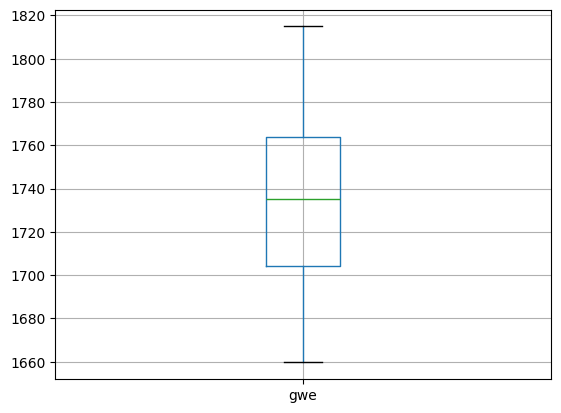

In [112]:
df.boxplot(column='gwe')